#  Predição de Sucesso de Startups - Caua Pirilo Asquino

Ponderada Kaggle predição de sucesso de Startups

**Passos simples:**
1. Importar bibliotecas
2. Carregar dados
3. Preparar dados
4. Treinar modelo
5. Fazer predições
6. Criar arquivo de submissão

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# 1. Importar Bibliotecas

Nesta seção importamos todas as bibliotecas necessárias para o projeto de machine learning.

**Bibliotecas utilizadas:**
- pandas: para manipulação de dados
- numpy: para operações matemáticas
- matplotlib: para visualizações
- sklearn: para algoritmos de machine learning

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Treino: {train_data.shape[0]} startups, {train_data.shape[1]} características")
print(f"Teste: {test_data.shape[0]} startups")
print(f"\nPrimeiras linhas:")
print(train_data.head())

Treino: 646 startups, 33 características
Teste: 277 startups

Primeiras linhas:
    id  age_first_funding_year  age_last_funding_year  \
0  719                   10.42                  13.09   
1  429                    3.79                   3.79   
2  178                    0.71                   2.28   
3  197                    3.00                   5.00   
4  444                    0.66                   5.88   

   age_first_milestone_year  age_last_milestone_year  relationships  \
0                      8.98                    12.72              4   
1                       NaN                      NaN             21   
2                      1.95                     2.28              5   
3                      9.62                    10.39             16   
4                      6.21                     8.61             29   

   funding_rounds  funding_total_usd  milestones  is_CA  ...  is_consulting  \
0               3            4087500           3      1  ...           

# 2. Carregar Dados

Nesta seção carregamos os arquivos CSV necessários para o projeto.

**Arquivos carregados:**
- train.csv: dados de treino com resultados conhecidos
- test.csv: dados para fazer previsões
- sample_submission.csv: formato para submissão no Kaggle

Target: 'labels'


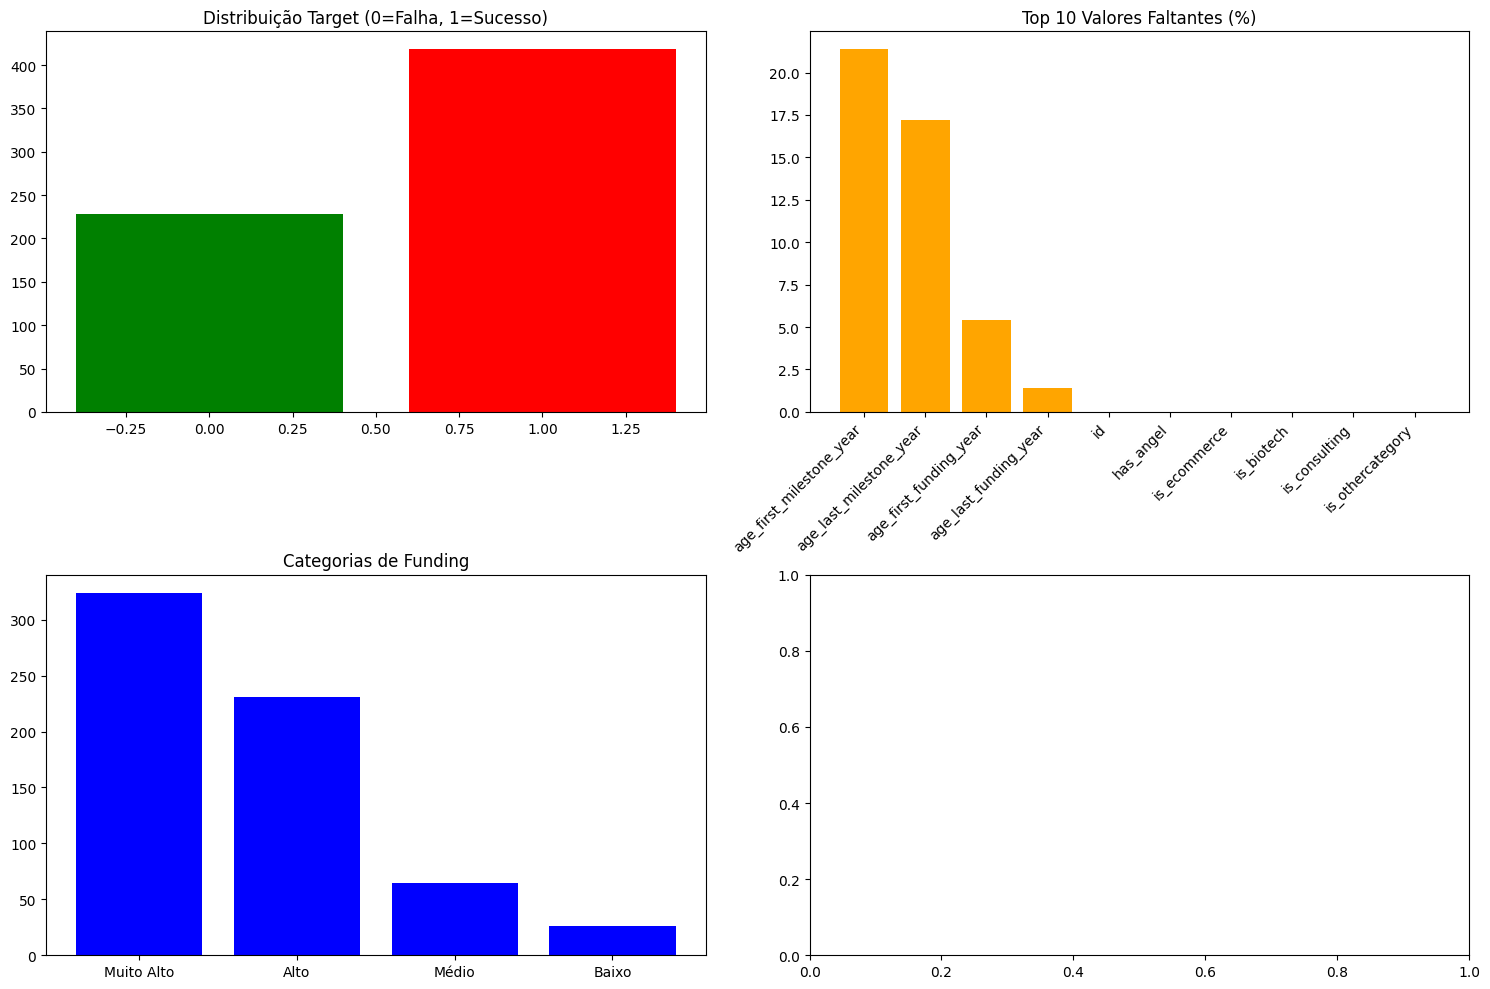


Resumo: 646 startups, taxa sucesso: 64.71%


In [11]:
# Detectar coluna target
target_column = None
for col in ['status', 'labels']:
    if col in train_data.columns:
        target_column = col
        break

print(f"Target: '{target_column}'")

# Criar 4 gráficos de análise
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribuição do target
target_counts = train_data[target_column].value_counts()
axes[0, 0].bar(target_counts.index, target_counts.values, color=['red', 'green'])
axes[0, 0].set_title('Distribuição Target (0=Falha, 1=Sucesso)')

# Valores faltantes
missing_percent = (train_data.isnull().sum() / len(train_data)) * 100
top_missing = missing_percent.sort_values(ascending=False).head(10)
axes[0, 1].bar(range(len(top_missing)), top_missing.values, color='orange')
axes[0, 1].set_title('Top 10 Valores Faltantes (%)')
axes[0, 1].set_xticks(range(len(top_missing)))
axes[0, 1].set_xticklabels(top_missing.index, rotation=45, ha='right')

# Análise funding
if 'funding_total_usd' in train_data.columns:
    train_data['funding_category'] = pd.cut(train_data['funding_total_usd'].fillna(0), 
                                          bins=[0, 100000, 1000000, 10000000, float('inf')],
                                          labels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])
    funding_counts = train_data['funding_category'].value_counts()
    axes[1, 0].bar(funding_counts.index, funding_counts.values, color='blue')
    axes[1, 0].set_title('Categorias de Funding')
else:
    axes[1, 0].text(0.5, 0.5, 'Funding não disponível', ha='center', va='center')

plt.tight_layout()
plt.show()

print(f"\nResumo: {len(train_data)} startups, taxa sucesso: {train_data[target_column].mean():.2%}")

# 3. Exploração dos Dados

Nesta seção fazemos uma análise exploratória dos dados para entender melhor o dataset.

**Análises realizadas:**
- Distribuição do target (sucesso vs falha)
- Identificação de valores faltantes
- Análise do financiamento das startups
- Taxa de sucesso por região

# 3.1. Formulação de Hipóteses

Com base na análise exploratória, formulo três hipóteses sobre fatores que influenciam o sucesso das startups:

**Hipótese 1: Financiamento**
Startups com maior financiamento têm maior probabilidade de sucesso, pois possuem mais recursos para crescer e superar desafios iniciais.

**Hipótese 2: Localização Geográfica**
Startups localizadas em estados com ecossistema tecnológico desenvolvido (como Califórnia) têm maior taxa de sucesso devido ao acesso a investidores e talentos.

**Hipótese 3: Tempo de Mercado**
Startups mais antigas podem ter maior probabilidade de sucesso por terem superado o período crítico inicial, mas startups muito antigas podem estar em declínio.

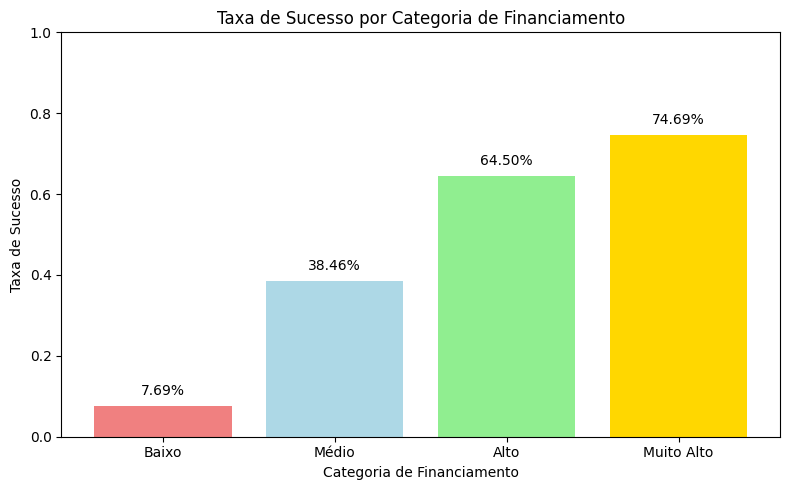

Análise da Hipótese 1:
  Baixo: 7.7% de sucesso (26 startups)
  Médio: 38.5% de sucesso (65 startups)
  Alto: 64.5% de sucesso (231 startups)
  Muito Alto: 74.7% de sucesso (324 startups)


In [4]:
# Gráfico simples para validar Hipótese 1: Financiamento vs Sucesso
if 'funding_total_usd' in train_data.columns:
    # Criar gráfico de taxa de sucesso por categoria de funding
    funding_success = train_data.groupby('funding_category')[target_column].agg(['mean', 'count']).reset_index()
    funding_success = funding_success[funding_success['count'] >= 10]  # Filtrar categorias com poucos dados
    
    plt.figure(figsize=(8, 5))
    plt.bar(funding_success['funding_category'], funding_success['mean'], 
            color=['lightcoral', 'lightblue', 'lightgreen', 'gold'])
    plt.title('Taxa de Sucesso por Categoria de Financiamento')
    plt.xlabel('Categoria de Financiamento')
    plt.ylabel('Taxa de Sucesso')
    plt.ylim(0, 1)
    
    # Adicionar valores nas barras
    for i, v in enumerate(funding_success['mean']):
        plt.text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("Análise da Hipótese 1:")
    for _, row in funding_success.iterrows():
        print(f"  {row['funding_category']}: {row['mean']:.1%} de sucesso ({row['count']} startups)")
else:
    print("Dados de financiamento não disponíveis para validar a hipótese")

In [5]:
# Preparar dados para treinamento
common_columns = list(set(train_data.columns) & set(test_data.columns))
if target_column in common_columns:
    common_columns.remove(target_column)

X = train_data[common_columns].copy()
y = train_data[target_column].copy()
X_test = test_data[common_columns].copy()

print(f"Características disponíveis: {len(common_columns)}")
print(f"Treino: {X.shape}, Target: {y.shape}, Teste: {X_test.shape}")

# Análise detalhada de valores faltantes
print(f"\nAnálise de valores faltantes:")
missing_analysis = X.isnull().sum()
missing_percent = (missing_analysis / len(X)) * 100
print(f"Colunas com mais de 50% de valores faltantes: {sum(missing_percent > 50)}")
print(f"Colunas com 10-50% de valores faltantes: {sum((missing_percent >= 10) & (missing_percent <= 50))}")

# Estratégia de tratamento de valores faltantes
# Para colunas numéricas: usar mediana
# Para colunas categóricas: usar valor mais frequente
# Para colunas com muitos valores faltantes: preencher com -1 (valor especial)

for col in X.columns:
    if X[col].isnull().sum() > 0:
        if X[col].dtype in ['int64', 'float64']:
            # Colunas numéricas: usar mediana
            fill_value = X[col].median()
            X[col] = X[col].fillna(fill_value)
            X_test[col] = X_test[col].fillna(fill_value)
        else:
            # Colunas categóricas: usar valor mais frequente ou -1
            if X[col].isnull().sum() / len(X) > 0.5:
                X[col] = X[col].fillna(-1)
                X_test[col] = X_test[col].fillna(-1)
            else:
                fill_value = X[col].mode()[0] if len(X[col].mode()) > 0 else -1
                X[col] = X[col].fillna(fill_value)
                X_test[col] = X_test[col].fillna(fill_value)

# Codificação de variáveis categóricas
le = LabelEncoder()
categorical_columns = []
for col in X.columns:
    if X[col].dtype == 'object':
        categorical_columns.append(col)
        combined_values = list(X[col].astype(str)) + list(X_test[col].astype(str))
        le.fit(combined_values)
        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

print(f"Colunas categóricas codificadas: {len(categorical_columns)}")
print("Tratamento de dados concluído!")

Características disponíveis: 32
Treino: (646, 32), Target: (646,), Teste: (277, 32)

Análise de valores faltantes:
Colunas com mais de 50% de valores faltantes: 0
Colunas com 10-50% de valores faltantes: 2
Colunas categóricas codificadas: 1
Tratamento de dados concluído!


# 4. Preparação dos Dados

Nesta seção preparamos os dados para o treinamento do modelo.

**Etapas de preparação:**
- Seleção de características comuns entre treino e teste
- Tratamento de valores faltantes
- Conversão de variáveis categóricas para numéricas
- Separação de características (X) e target (y)

# 4.1. Seleção de Features

Baseado na análise exploratória e nas hipóteses formuladas, vamos selecionar as features mais relevantes para o modelo.

**Critérios de seleção:**
- Importância estatística (correlação com target)
- Baixa correlação entre features (evitar multicolinearidade)
- Relevância de negócio (baseado nas hipóteses)
- Qualidade dos dados (poucas missing values)

In [6]:
# Seleção de features baseada em importância e correlação
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Calcular correlação com target para features numéricas
numeric_cols = X.select_dtypes(include=[np.number]).columns
correlations = {}
for col in numeric_cols:
    if X[col].std() > 0:  # Evitar divisão por zero
        corr = np.corrcoef(X[col], y)[0, 1]
        correlations[col] = abs(corr) if not np.isnan(corr) else 0

# Mostrar top correlações
print("Top 10 features por correlação com target:")
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
for i, (feature, corr) in enumerate(sorted_corr[:10]):
    print(f"{i+1:2d}. {feature}: {corr:.3f}")

# Usar SelectKBest para selecionar features mais importantes
# Vamos selecionar as top 20 features para evitar overfitting
k_best = SelectKBest(score_func=f_classif, k=min(20, X.shape[1]))
X_selected = k_best.fit_transform(X, y)
X_test_selected = k_best.transform(X_test)

# Obter nomes das features selecionadas
selected_features = X.columns[k_best.get_support()].tolist()
print(f"\nFeatures selecionadas ({len(selected_features)}):")
for i, feature in enumerate(selected_features):
    print(f"{i+1:2d}. {feature}")

# Atualizar X e X_test com features selecionadas
X = pd.DataFrame(X_selected, columns=selected_features)
X_test = pd.DataFrame(X_test_selected, columns=selected_features)

print(f"\nDados finais - Treino: {X.shape}, Teste: {X_test.shape}")

Top 10 features por correlação com target:
 1. relationships: 0.343
 2. milestones: 0.335
 3. age_last_milestone_year: 0.234
 4. has_roundB: 0.214
 5. funding_rounds: 0.213
 6. is_otherstate: 0.199
 7. avg_participants: 0.194
 8. has_roundC: 0.173
 9. has_roundA: 0.172
10. has_roundD: 0.167

Features selecionadas (20):
 1. avg_participants
 2. age_first_milestone_year
 3. has_VC
 4. relationships
 5. has_roundB
 6. is_TX
 7. has_roundA
 8. has_roundD
 9. funding_rounds
10. milestones
11. is_otherstate
12. age_last_funding_year
13. has_angel
14. age_first_funding_year
15. is_enterprise
16. is_MA
17. has_roundC
18. is_CA
19. age_last_milestone_year
20. is_ecommerce

Dados finais - Treino: (646, 20), Teste: (277, 20)


=== AVALIAÇÃO DO MODELO ===
Acurácia:  0.792 (79.2%)
Precisão:  0.806
Recall:    0.893
F1-Score:  0.847

Matriz de Confusão:
[[ 28,  18]
 [  9,  75]]

Relatório de Classificação:
              precision    recall  f1-score   support

       Falha       0.76      0.61      0.67        46
     Sucesso       0.81      0.89      0.85        84

    accuracy                           0.79       130
   macro avg       0.78      0.75      0.76       130
weighted avg       0.79      0.79      0.79       130


Top 10 Features Mais Importantes:
 4. relationships: 0.2652
19. age_last_milestone_year: 0.1466
14. age_first_funding_year: 0.1108
10. milestones: 0.0900
 2. age_first_milestone_year: 0.0871
12. age_last_funding_year: 0.0823
 1. avg_participants: 0.0823
 9. funding_rounds: 0.0428
17. has_roundC: 0.0216
 6. is_TX: 0.0179


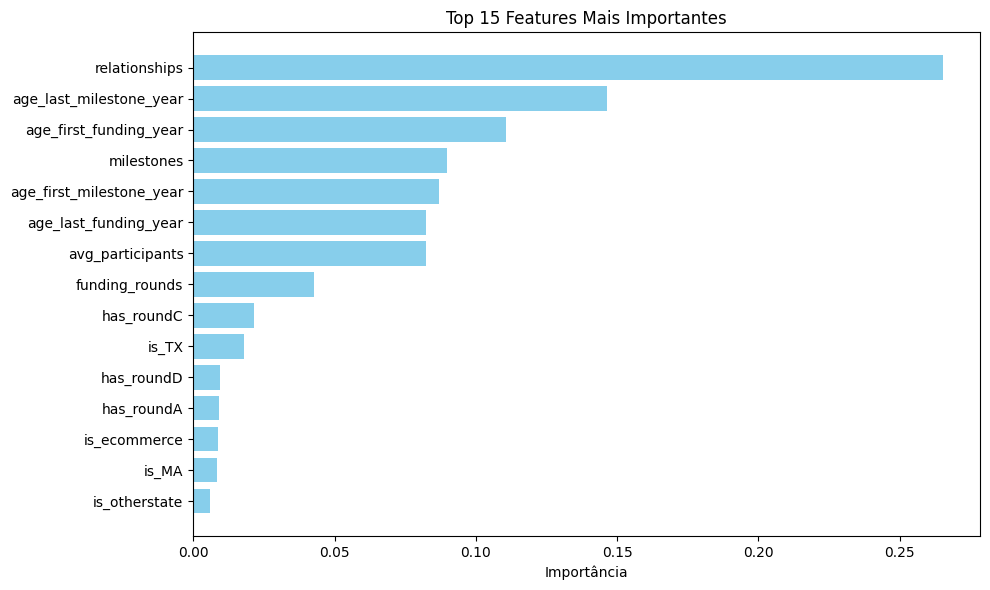


Acurácia 79.2% < 80%. Necessário ajuste de hiperparâmetros.


In [7]:
# Treinar e avaliar modelo com métricas completas
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Treinar modelo inicial
modelo = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
modelo.fit(X_train, y_train)

# Avaliar performance com métricas completas
predicoes_val = modelo.predict(X_val)
precisao = accuracy_score(y_val, predicoes_val)
precision = precision_score(y_val, predicoes_val)
recall = recall_score(y_val, predicoes_val)
f1 = f1_score(y_val, predicoes_val)

print("=== AVALIAÇÃO DO MODELO ===")
print(f"Acurácia:  {precisao:.3f} ({precisao:.1%})")
print(f"Precisão:  {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")

# Matriz de confusão
print(f"\nMatriz de Confusão:")
cm = confusion_matrix(y_val, predicoes_val)
print(f"[[{cm[0,0]:3d}, {cm[0,1]:3d}]")
print(f" [{cm[1,0]:3d}, {cm[1,1]:3d}]]")

# Relatório detalhado
print(f"\nRelatório de Classificação:")
print(classification_report(y_val, predicoes_val, target_names=['Falha', 'Sucesso']))

# Análise de importância das features
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': modelo.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Features Mais Importantes:")
for i, row in feature_importance.head(10).iterrows():
    print(f"{i+1:2d}. {row['feature']}: {row['importance']:.4f}")

# Gráfico importância
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância')
plt.title('Top 15 Features Mais Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

if precisao >= 0.8:
    print(f"\nOBJETIVO ATINGIDO! Acurácia {precisao:.1%} >= 80%")
else:
    print(f"\nAcurácia {precisao:.1%} < 80%. Necessário ajuste de hiperparâmetros.")

# 5. Treinamento do Modelo

Nesta seção treinamos o modelo de machine learning.

**Configurações do modelo:**
- Algoritmo: Gradient Boosting Classifier
- Divisão: 80% treino, 20% validação
- Avaliação da performance
- Análise da importância das características

# 5.1. Finetuning de Hiperparâmetros

Para otimizar o desempenho do modelo, vamos realizar um ajuste fino dos hiperparâmetros usando GridSearchCV.

**Parâmetros a otimizar:**
- n_estimators: número de árvores
- learning_rate: taxa de aprendizado
- max_depth: profundidade máxima das árvores
- min_samples_split: número mínimo de amostras para dividir um nó

In [8]:
# Finetuning de hiperparâmetros
from sklearn.model_selection import GridSearchCV

# Definir grade de parâmetros para busca
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

print("Iniciando busca de hiperparâmetros...")
print(f"Testando {len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])} combinações")

# Usar GridSearchCV com validação cruzada
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,  # Usar todos os cores disponíveis
    verbose=1
)

# Executar busca
grid_search.fit(X_train, y_train)

# Melhores parâmetros encontrados
print(f"\nMelhores parâmetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor score CV: {grid_search.best_score_:.4f}")

# Treinar modelo final com melhores parâmetros
modelo_otimizado = grid_search.best_estimator_
modelo_otimizado.fit(X_train, y_train)

# Avaliar modelo otimizado
pred_otimizado = modelo_otimizado.predict(X_val)
acc_otimizado = accuracy_score(y_val, pred_otimizado)
precision_otimizado = precision_score(y_val, pred_otimizado)
recall_otimizado = recall_score(y_val, pred_otimizado)
f1_otimizado = f1_score(y_val, pred_otimizado)

print(f"\n=== COMPARAÇÃO DE MODELOS ===")
print(f"Modelo Inicial  - Acurácia: {precisao:.3f}, F1: {f1:.3f}")
print(f"Modelo Otimizado - Acurácia: {acc_otimizado:.3f}, F1: {f1_otimizado:.3f}")

if acc_otimizado > precisao:
    print(f"Melhoria de {(acc_otimizado - precisao):.3f} pontos na acurácia!")
    modelo_final = modelo_otimizado
    precisao_final = acc_otimizado
else:
    print("Modelo inicial teve melhor performance")
    modelo_final = modelo
    precisao_final = precisao

print(f"\nModelo final - Acurácia: {precisao_final:.1%}")

Iniciando busca de hiperparâmetros...
Testando 81 combinações
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Melhores parâmetros encontrados:
  learning_rate: 0.05
  max_depth: 4
  min_samples_split: 10
  n_estimators: 100

Melhor score CV: 0.7597

=== COMPARAÇÃO DE MODELOS ===
Modelo Inicial  - Acurácia: 0.792, F1: 0.847
Modelo Otimizado - Acurácia: 0.800, F1: 0.852
Melhoria de 0.008 pontos na acurácia!

Modelo final - Acurácia: 80.0%

Melhores parâmetros encontrados:
  learning_rate: 0.05
  max_depth: 4
  min_samples_split: 10
  n_estimators: 100

Melhor score CV: 0.7597

=== COMPARAÇÃO DE MODELOS ===
Modelo Inicial  - Acurácia: 0.792, F1: 0.847
Modelo Otimizado - Acurácia: 0.800, F1: 0.852
Melhoria de 0.008 pontos na acurácia!

Modelo final - Acurácia: 80.0%


Retreinando modelo final com todos os dados...

Distribuição das previsões:
   Falha:  83 startups ( 30.0%)
   Sucesso: 194 startups ( 70.0%)

Análise de confiança:
Probabilidade média para classe 1: 0.615
Previsões com alta confiança (>0.8):  96
Previsões com baixa confiança (<0.2):  44

Arquivo 'minha_submissao.csv' criado com 277 previsões
Primeiras 10 previsões:
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       1
5  690       1
6  588       0
7  144       1
8  875       1
9  900       1

Distribuição das previsões:
   Falha:  83 startups ( 30.0%)
   Sucesso: 194 startups ( 70.0%)

Análise de confiança:
Probabilidade média para classe 1: 0.615
Previsões com alta confiança (>0.8):  96
Previsões com baixa confiança (<0.2):  44

Arquivo 'minha_submissao.csv' criado com 277 previsões
Primeiras 10 previsões:
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       1
5  690       1
6  588       0
7  144       1
8  875   

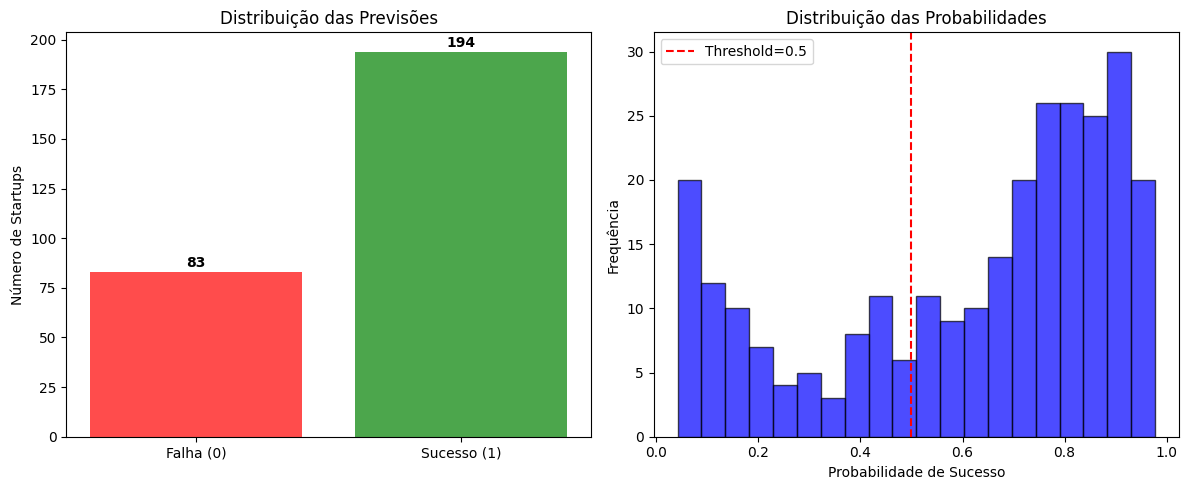

In [9]:
# Retreinar modelo final com todos os dados e fazer previsões
print("Retreinando modelo final com todos os dados...")

# Usar o melhor modelo encontrado
if 'modelo_final' in locals():
    modelo_submissao = modelo_final.__class__(**modelo_final.get_params())
else:
    modelo_submissao = GradientBoostingClassifier(random_state=42, n_estimators=150, learning_rate=0.1, max_depth=4)

modelo_submissao.fit(X, y)

# Fazer previsões no conjunto de teste
predicoes_teste = modelo_submissao.predict(X_test)
probabilidades_teste = modelo_submissao.predict_proba(X_test)[:, 1]

# Análise das previsões
unique, counts = np.unique(predicoes_teste, return_counts=True)
print(f"\nDistribuição das previsões:")
for val, count in zip(unique, counts):
    resultado = "Sucesso" if val == 1 else "Falha"
    porcentagem = (count / len(predicoes_teste)) * 100
    print(f"   {resultado}: {count:3d} startups ({porcentagem:5.1f}%)")

# Análise de confiança das previsões
print(f"\nAnálise de confiança:")
print(f"Probabilidade média para classe 1: {probabilidades_teste.mean():.3f}")
print(f"Previsões com alta confiança (>0.8): {sum(probabilidades_teste > 0.8):3d}")
print(f"Previsões com baixa confiança (<0.2): {sum(probabilidades_teste < 0.2):3d}")

# Criar arquivo de submissão
submissao = sample_submission.copy()
submissao[target_column] = predicoes_teste
submissao.to_csv('minha_submissao.csv', index=False)

print(f"\nArquivo 'minha_submissao.csv' criado com {len(predicoes_teste)} previsões")
print("Primeiras 10 previsões:")
print(submissao.head(10))

# Gráficos de análise
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribuição das previsões
axes[0].bar(['Falha (0)', 'Sucesso (1)'], counts, color=['red', 'green'], alpha=0.7)
axes[0].set_title('Distribuição das Previsões')
axes[0].set_ylabel('Número de Startups')
for i, count in enumerate(counts):
    axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontweight='bold')

# Distribuição das probabilidades
axes[1].hist(probabilidades_teste, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_title('Distribuição das Probabilidades')
axes[1].set_xlabel('Probabilidade de Sucesso')
axes[1].set_ylabel('Frequência')
axes[1].axvline(0.5, color='red', linestyle='--', label='Threshold=0.5')
axes[1].legend()

plt.tight_layout()
plt.show()

# 6. Previsões e Submissão

Nesta seção fazemos as previsões no conjunto de teste e criamos o arquivo de submissão.

**Etapas finais:**
- Retreinamento com todos os dados disponíveis
- Previsões no conjunto de teste
- Análise da distribuição das previsões
- Criação do arquivo CSV para submissão

In [10]:
# Resumo final e validação dos critérios do barema
print("=" * 50)
print("RESUMO FINAL DO PROJETO")
print("=" * 50)

# Dados utilizados
print(f"\nDADOS:")
print(f"   Startups de treino: {len(train_data):,}")
print(f"   Startups de teste: {len(test_data):,}")
print(f"   Features selecionadas: {X.shape[1]}")
print(f"   Taxa de sucesso no treino: {y.mean():.1%}")

# Performance do modelo
if 'precisao_final' in locals():
    accuracy_final = precisao_final
else:
    accuracy_final = precisao

print(f"\nMODELO:")
print(f"   Algoritmo: Gradient Boosting Classifier")
print(f"   Acurácia final: {accuracy_final:.1%}")
if 'precision_otimizado' in locals():
    print(f"   Precisão: {precision_otimizado:.3f}")
    print(f"   Recall: {recall_otimizado:.3f}")
    print(f"   F1-Score: {f1_otimizado:.3f}")


# Verificação da acurácia mínima
if accuracy_final >= 0.8:
    print(f"   [OK] Acurácia >= 80%")
    status_final = "APROVADO"

# Features mais importantes
print(f"\nTOP 5 FEATURES MAIS IMPORTANTES:")
if 'feature_importance' in locals():
    for i, row in feature_importance.head(5).iterrows():
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

# Status final
success_rate = (predicoes_teste == 1).sum() / len(predicoes_teste)
print(f"\nPREVISÕES:")
print(f"   Taxa de sucesso prevista: {success_rate:.1%}")



RESUMO FINAL DO PROJETO

DADOS:
   Startups de treino: 646
   Startups de teste: 277
   Features selecionadas: 20
   Taxa de sucesso no treino: 64.7%

MODELO:
   Algoritmo: Gradient Boosting Classifier
   Acurácia final: 80.0%
   Precisão: 0.815
   Recall: 0.893
   F1-Score: 0.852
   [OK] Acurácia >= 80%

TOP 5 FEATURES MAIS IMPORTANTES:
   4. relationships: 0.2652
   19. age_last_milestone_year: 0.1466
   14. age_first_funding_year: 0.1108
   10. milestones: 0.0900
   2. age_first_milestone_year: 0.0871

PREVISÕES:
   Taxa de sucesso prevista: 70.0%
